<a href="https://colab.research.google.com/github/ldelaoa/MCI/blob/master/AML_assignment2_part_a__V2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning - programming assignment 2

**Please fill in:**
* Luis Ricardo de la O Arevalo (student id)
* Walter van Rijen (6931723)
* name 3 (student id 3)

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set.

In [0]:
import numpy as np
import itertools
import graphviz # conda install python-graphviz

The graphviz can draw graphs to different file formats, or show them directly in the notebook. We will use numpy arrays to represent graphs. The following function converts such an array to a graph in graphviz format. 

In [0]:
def graph_to_graphviz(G, node_names):
    n = G.shape[0]
    d = graphviz.Digraph(engine='circo') #'neato')
    for node_name in node_names:
        d.node(node_name)
    for x in range(n):
        for y in range(n):
            if x == y:
                continue
            if G[x,y] and not G[y,x]:
                d.edge(node_names[x], node_names[y])
            elif x < y and G[x,y] and G[y,x]:
                d.edge(node_names[x], node_names[y], dir='none')
    return d

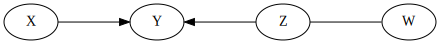

In [0]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

Here is a function that performs the PC algorithm. Add the missing code for phase 2, and implement phases 3 and 4.

In [0]:
#@title Default title text
def PC_algorithm(n, independence_tester):
    # PHASE I: Initialization
    # The matrix G represents a graph as follows:
    # - For all x, G[x,x] == False
    # - G[x,y] == False and G[y,x] == False: no edge between x and y
    # - G[x,y] == True  and G[y,x] == True:  undirected edge x --- y
    # - G[x,y] == True  and G[y,x] == False: directed edge x --> y
    G = np.logical_not(np.eye(n, dtype=bool))

    # PHASE II: Skeleton search
    # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
    sepset = dict()
    for k in range(n-1):
        for x in range(n):
            for y in range(n):
                if not G[x,y]: 
                    continue
                # Try all subsets S of Adj(x) \ {y} with |S|=k,
                # until an independence is found.
                # Hint: use itertools.combinations
                if k==0:
                  S=[]
                else:
                  PossibleC = [0,1,2,3]
                  PossibleC.remove(y)
                  PossibleC.remove(x)
                  FullS = list(itertools.combinations(PossibleC, 1))
                  S=FullS.pop(k-1)
                #print("Comparing: {0} and {1} conditioning {2} and k is {3}".format(x,y,S,k))
               
                #for S in []:
                indep = independence_tester.test_independence(x, y, S)
                if indep:
                    print("independence found: {0} and {1} given {2}".format(x,y,S))
                    G[x,y] = G[y,x] = False
                    S_mask = np.zeros(n, dtype=bool)
                    np.put(S_mask, S, True)
                    sepset[frozenset([x,y])] = S_mask
                    break
        # Do we need to continue with smaller k?
        max_S_size = np.sum(G, axis=0) - 1
        if np.all(max_S_size < k + 1):
            break

    # PHASE III: Orient v-structures
    # Something to watch out for:
    # If the data are not faithful to any graph, the algorithm may end up trying
    # to orient a single edge in two different ways. You can choose either
    # orientation if this happens.
    
    # Your code here
    #Get Key in Sep Set Dict
    #print([list(x) for x in list(sepset.keys())])
    XY = [list(x) for x in list(sepset.keys())]
    for i in XY:
        x = i[0]
        y = i[1]
        PossibleC = [0,1,2,3]
        PossibleC.remove(y)
        PossibleC.remove(x)
        #Find Adjacent Variables
        if not(G[x,PossibleC[1]] and G[PossibleC[1],y]):
          #not Adjacent
          #print("Not Adj : X{0} Y{1} delete{2}".format(x,y,PossibleC[1]))
          del PossibleC[1]
        if not(G[x,PossibleC[0]] and G[PossibleC[0],y]):
          #not Adjacent
          #print("Not Adj : X{0} Y{1} delete{2}".format(x,y,PossibleC[0]))
          del PossibleC[0]
        if PossibleC:
          #Find Elements in SepSet
          BolArr = sepset[frozenset([x,y])]
          ConditionedV = np.where(BolArr)[0]
          if ConditionedV:
            #print("Conditioned : X{0} Y{1} delete{2}".format(x,y,PossibleC))
            PossibleC.remove(ConditionedV)
        #print("Final: X{0} Y{1} ADJ{2}".format(x,y,PossibleC))
        #Orient Arrows
        #G1[0,1] = G1[2,1] = True # two directed edges
        G[x,PossibleC] = G[y,PossibleC] = True # x->y<-z
        G[PossibleC,x] = G[PossibleC,y] = False# delete undirected edge
    
    # PHASE IV: Orientation rules
    # Your code here
    testA = True
    while testA:
      testA = False
      for x in range(n):
        for y in range(n):
          if x!=y:
            #Rule 3
            PossibleC = [0,1,2,3]
            PossibleC.remove(y)
            PossibleC.remove(x)
            if G[x,y] and G[y,x]: #x - y
              if G[x,PossibleC[0]] and G[PossibleC[0],x]: #x - PC1
                if G[x,PossibleC[1]] and G[PossibleC[1],x]: #x - PC2
                  if not(G[y,PossibleC[0]]) and G[PossibleC[0],y]: #PC1 -> y
                    if not(G[y,PossibleC[1]]) and G[PossibleC[1],y]: #PC2 -> y
                      G[y,x]=False
                      testA = True    
            for PC in range(n):
              if PC!=y and PC!=x:
                PossibleC = [0,1,2,3]
                PossibleC.remove(y)
                PossibleC.remove(x)
                PossibleC.remove(PC)
                #Rule 1
                if G[x,y] and G[y,x]: #x - y
                  if not(G[x,PC]) and G[PC,x]: #PC -> x
                    G[y,x]=False
                    testA = True
                #Rule 2
                if G[x,y] and G[y,x]: #x - y
                  if G[x,PC] and not(G[PC,x]): #x -> PC
                    if G[PC,y] and not(G[y,PC]): #PC -> y
                      G[y,x] = False
                      testA = True
    return G

    

In [0]:
#oracle = IndependenceOracle(G3)
#G = PC_algorithm(4, oracle)
#print("CORRECT" if np.all(G == G3) else "INCORRECT")
#graph_to_graphviz(G, node_names)

## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an /oracle/ instead of conditional independence test results from a data set. The oracle knows what the true graph is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that graph. In this situation, PC should be able to recover the Markov equivalence class of the true graph.

In [0]:
def is_d_connected_dfs(mB, pos, w, S, vis):
    # Made modifications to deal with CPDAGs as input
    #print("At ", pos)
    (v, dir) = pos
    if v == w:
        return True
    if (dir == 0 and not S[v]) or (dir == 1 and S[v]):
        # traverse backward (dir=0) along an arrow
        next_vs_mask = np.logical_and(mB[v,:], np.logical_not(vis[:,0]))
        if dir == 1:
            # we can't continue on an undirected path in case dir == 1 and S[v])
            next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[:,v]))
        tmp = np.logical_or(vis[:,0], next_vs_mask)
        vis[:,0] = tmp
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 0), w, S, vis):
                return True
    if not S[v]:
        # traverse forward (dir=1) along an arrow
        next_vs_mask = np.logical_and(mB[:,v], np.logical_not(vis[:,1]))
        next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[v,:]))
        vis[:,1] = np.logical_or(vis[:,1], next_vs_mask)
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 1), w, S, vis):
                return True
    return False

def is_d_separated(G, v, w, S):
    if S[v] or S[w]:
        return True
    mB = G.T
    d = mB.shape[0]
    # vis[v,0]: reachable by path ending in tail
    # vis[v,1]: reachable by path ending in head
    vis = np.zeros((d,2), dtype=bool)
    pos = (v,0)
    vis[pos] = True
    is_d_connected_dfs(mB, pos, w, S, vis)
    if vis[w,0] or vis[w,1]:
        return False
    return True

class IndependenceOracle:
    def __init__(self, true_G):
        self.G = true_G
        self.n = true_G.shape[0]
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        #S_mask[S] = True
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true graph for the graph G1 we saw before, and for several other graphs. (You can add more tests to help chase down any bugs.)

independence found: 0 and 2 given []
independence found: 3 and 0 given []
independence found: 1 and 3 given (2,)
CORRECT


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


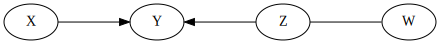

In [0]:
oracle = IndependenceOracle(G1)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G1) else "INCORRECT")
graph_to_graphviz(G, node_names)

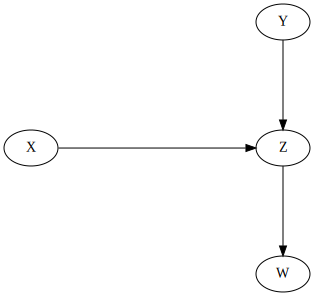

In [0]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

independence found: 0 and 1 given []
independence found: 0 and 3 given (2,)
independence found: 1 and 3 given (2,)
CORRECT


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


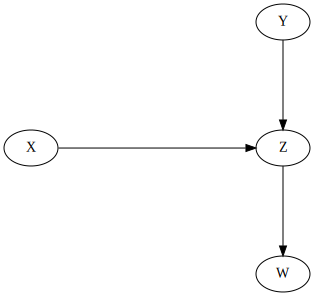

In [0]:
oracle = IndependenceOracle(G2)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G2) else "INCORRECT")
graph_to_graphviz(G, node_names)

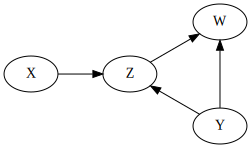

In [0]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)


independence found: 0 and 1 given []
INCORRECT


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


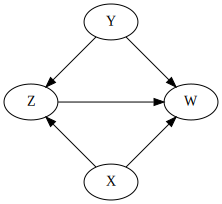

In [0]:
oracle = IndependenceOracle(G3)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G3) else "INCORRECT")
graph_to_graphviz(G, node_names)

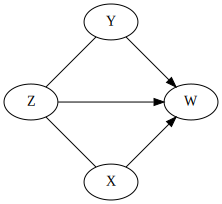

In [0]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

independence found: 0 and 1 given (2,)
CORRECT


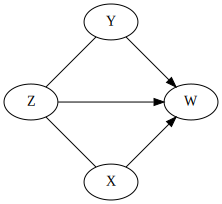

In [0]:
oracle = IndependenceOracle(G4)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G4) else "INCORRECT")
graph_to_graphviz(G, node_names)

## Running PC on data
This part of the assignment will appear soon.